
Predictions for 2023-2024:
Rice - Basmati:
  Predicted value: 1911.96


TypeError: unsupported format string passed to numpy.ndarray.__format__

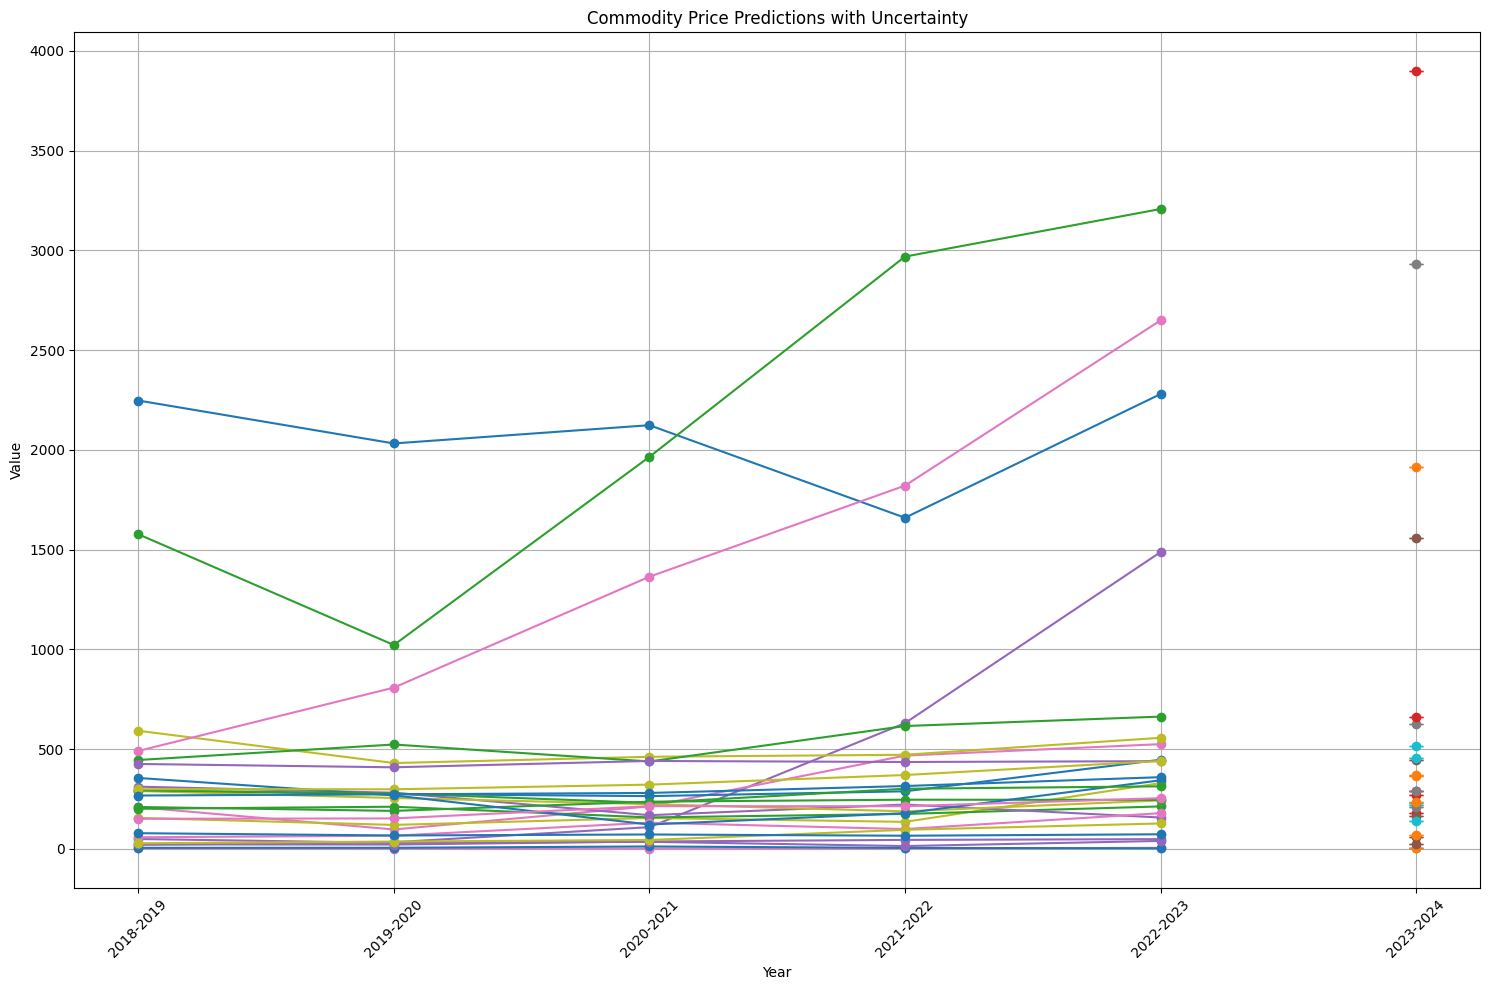

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess the data
def load_data():
    # Create the DataFrame
    data = {
        'Commodity': [
            'Rice - Basmati', 'Rice (Other than Basmati)', 'Wheat', 'Other Cereals',
            'Pulses', 'Tobacco Unmanufactured', 'Tobacco Manufactured', 'Cashew',
            'Cashew Nut Shell Liquid', 'Sesame Seeds', 'Niger Seeds', 'Groundnut',
            'Other Oil Seeds', 'Vegetable Oils', 'Oil Meals', 'Guar Gum Meal',
            'Castor Oil', 'Shellac', 'Sugar', 'Molasses', 'Fruits / Vegetable Seeds',
            'Fresh Fruits', 'Fresh Vegetables', 'Processed Vegetables',
            'Processed Fruits and Juices', 'Cereal Preparations'
        ],
        '2018-2019': [2247.34, 1577.02, 20.84, 208.83, 155.13, 291.99, 200.98, 311.77,
                      2.44, 289.83, 5.11, 209.77, 49.37, 58.14, 591.9, 355.38, 445.41,
                      22.27, 490.83, 27.76, 78.52, 293.03, 425.53, 150.83, 299.22, 267.44],
        '2019-2020': [2032.1, 1021.77, 33.14, 97.22, 120.09, 274.61, 211.18, 281.3,
                      1.55, 254.97, 5.41, 190.32, 30.07, 65.97, 430.11, 268.09, 523.11,
                      21.7, 808.32, 36.7, 67.01, 277.68, 408.81, 152.54, 298.57, 273.45],
        '2020-2021': [2123.58, 1964.87, 108.77, 212.99, 154.76, 264.23, 157.66, 168.72,
                      1.03, 224.11, 12.02, 236.51, 35.35, 131.22, 461.65, 122.03, 438.01,
                      36.91, 1364.08, 44.49, 72.09, 230.65, 440.63, 213.87, 321.88, 280.21],
        '2021-2022': [1659.6, 2968.77, 630.15, 467.42, 135.25, 288.53, 174.91, 222.02,
                      1.89, 188.05, 4.77, 246.42, 14.04, 99.22, 471.65, 178.85, 615.62,
                      44.86, 1820.68, 95.4, 65.81, 301.3, 435.41, 213.77, 370.12, 314.92],
        '2022-2023': [2279.66, 3207.29, 1487.47, 524.85, 329.55, 446.72, 212.77, 157.09,
                      5.09, 242.87, 2.82, 245.57, 39.76, 178.9, 556.61, 343.65, 662.93,
                      48.8, 2649.0, 127.28, 73.03, 313.46, 439.52, 254.01, 440.62, 359.31]
    }
    
    df = pd.DataFrame(data)
    return df

# Create sequences for LSTM
def create_sequences(data, sequence_length=5):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Build LSTM-MCDO model
def build_model(sequence_length, n_features):
    model = Sequential([
        LSTM(64, input_shape=(sequence_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Monte Carlo predictions with dropout
def mc_predict(model, X, n_iterations=100):
    predictions = []
    for _ in range(n_iterations):
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions)
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

# Main prediction function
def predict_commodities(df):
    predictions = {}
    uncertainties = {}
    
    # Process each commodity
    for commodity in df['Commodity'].values:
        # Extract time series data for the commodity
        data = df[df['Commodity'] == commodity].iloc[:, 1:].values.flatten()
        
        # Scale the data
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data.reshape(-1, 1))
        
        # Create sequences
        X, y = create_sequences(data_scaled, sequence_length=3)
        
        # Build and train model
        model = build_model(3, 1)
        model.fit(X, y, epochs=100, batch_size=4, verbose=0)
        
        # Prepare input for prediction
        last_sequence = data_scaled[-3:].reshape(1, 3, 1)
        
        # Make prediction with uncertainty
        mean_pred, std_pred = mc_predict(model, last_sequence)
        
        # Inverse transform predictions
        prediction = scaler.inverse_transform(mean_pred)[0][0]
        uncertainty = std_pred[0][0] * (scaler.data_max_ - scaler.data_min_)
        
        predictions[commodity] = prediction
        uncertainties[commodity] = uncertainty
    
    return predictions, uncertainties

# Visualization function
def plot_predictions(df, predictions, uncertainties):
    plt.figure(figsize=(15, 10))
    
    # Plot actual values and predictions for each commodity
    years = df.columns[1:].astype(str)
    next_year = '2023-2024'
    
    for commodity in df['Commodity']:
        values = df[df['Commodity'] == commodity].iloc[:, 1:].values.flatten()
        
        plt.plot(years, values, marker='o', label=f'{commodity} (Actual)')
        
        # Plot prediction with uncertainty
        plt.errorbar(next_year, predictions[commodity], 
                    yerr=uncertainties[commodity], 
                    fmt='o', capsize=5,
                    label=f'{commodity} (Predicted)')
    
    plt.title('Commodity Price Predictions with Uncertainty')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    return plt

# Main execution
def main():
    # Load data
    df = load_data()
    
    # Make predictions
    predictions, uncertainties = predict_commodities(df)
    
    # Create visualization
    plt = plot_predictions(df, predictions, uncertainties)
    
    # Print predictions with uncertainties
    print("\nPredictions for 2023-2024:")
    for commodity in predictions:
        print(f"{commodity}:")
        print(f"  Predicted value: {predictions[commodity]:.2f}")
        print(f"  Uncertainty: ±{uncertainties[commodity]:.2f}")
    
    plt.show()

if __name__ == "__main__":
    main()



Predictions for 2023-2024:
--------------------------------------------------
Rice - Basmati:
  Predicted value: 1925.64
  Uncertainty: ±0.00
--------------------------------------------------
Rice (Other than Basmati):
  Predicted value: 3812.67
  Uncertainty: ±0.00
--------------------------------------------------
Wheat:
  Predicted value: 1673.89
  Uncertainty: ±0.00
--------------------------------------------------
Other Cereals:
  Predicted value: 621.19
  Uncertainty: ±0.00
--------------------------------------------------
Pulses:
  Predicted value: 225.62
  Uncertainty: ±0.00
--------------------------------------------------
Tobacco Unmanufactured:
  Predicted value: 359.30
  Uncertainty: ±0.00
--------------------------------------------------
Tobacco Manufactured:
  Predicted value: 181.38
  Uncertainty: ±0.00
--------------------------------------------------
Cashew:
  Predicted value: 167.21
  Uncertainty: ±0.00
--------------------------------------------------
Cashew 

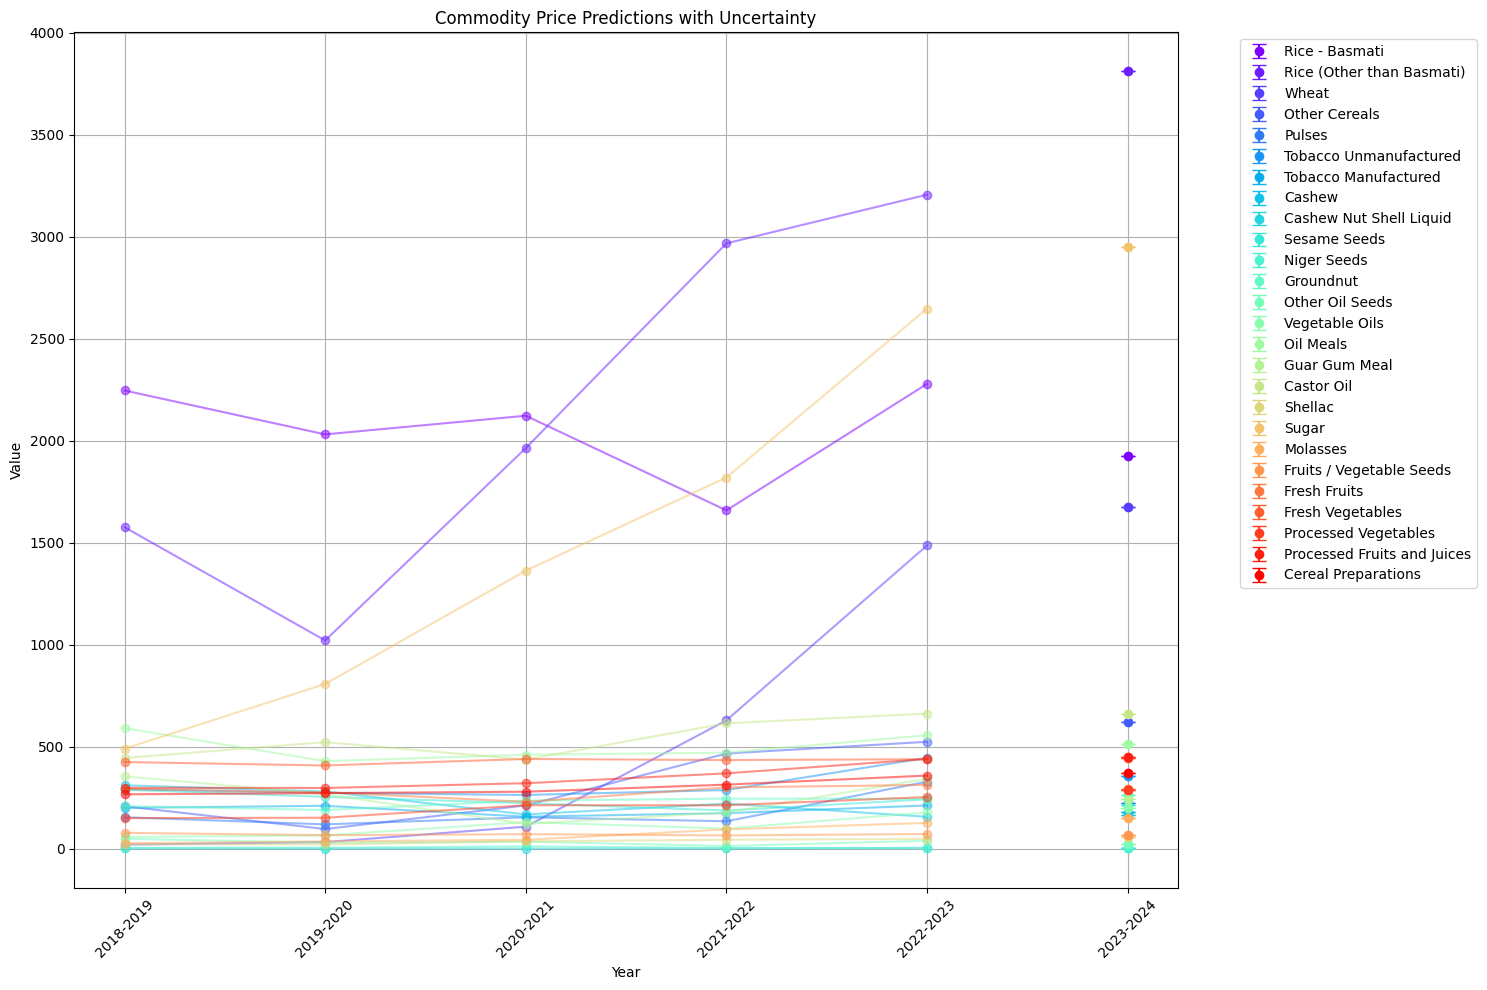

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess the data
def load_data():
    # Create the DataFrame
    data = {
        'Commodity': [
            'Rice - Basmati', 'Rice (Other than Basmati)', 'Wheat', 'Other Cereals',
            'Pulses', 'Tobacco Unmanufactured', 'Tobacco Manufactured', 'Cashew',
            'Cashew Nut Shell Liquid', 'Sesame Seeds', 'Niger Seeds', 'Groundnut',
            'Other Oil Seeds', 'Vegetable Oils', 'Oil Meals', 'Guar Gum Meal',
            'Castor Oil', 'Shellac', 'Sugar', 'Molasses', 'Fruits / Vegetable Seeds',
            'Fresh Fruits', 'Fresh Vegetables', 'Processed Vegetables',
            'Processed Fruits and Juices', 'Cereal Preparations'
        ],
        '2018-2019': [2247.34, 1577.02, 20.84, 208.83, 155.13, 291.99, 200.98, 311.77,
                      2.44, 289.83, 5.11, 209.77, 49.37, 58.14, 591.9, 355.38, 445.41,
                      22.27, 490.83, 27.76, 78.52, 293.03, 425.53, 150.83, 299.22, 267.44],
        '2019-2020': [2032.1, 1021.77, 33.14, 97.22, 120.09, 274.61, 211.18, 281.3,
                      1.55, 254.97, 5.41, 190.32, 30.07, 65.97, 430.11, 268.09, 523.11,
                      21.7, 808.32, 36.7, 67.01, 277.68, 408.81, 152.54, 298.57, 273.45],
        '2020-2021': [2123.58, 1964.87, 108.77, 212.99, 154.76, 264.23, 157.66, 168.72,
                      1.03, 224.11, 12.02, 236.51, 35.35, 131.22, 461.65, 122.03, 438.01,
                      36.91, 1364.08, 44.49, 72.09, 230.65, 440.63, 213.87, 321.88, 280.21],
        '2021-2022': [1659.6, 2968.77, 630.15, 467.42, 135.25, 288.53, 174.91, 222.02,
                      1.89, 188.05, 4.77, 246.42, 14.04, 99.22, 471.65, 178.85, 615.62,
                      44.86, 1820.68, 95.4, 65.81, 301.3, 435.41, 213.77, 370.12, 314.92],
        '2022-2023': [2279.66, 3207.29, 1487.47, 524.85, 329.55, 446.72, 212.77, 157.09,
                      5.09, 242.87, 2.82, 245.57, 39.76, 178.9, 556.61, 343.65, 662.93,
                      48.8, 2649.0, 127.28, 73.03, 313.46, 439.52, 254.01, 440.62, 359.31]
    }
    
    df = pd.DataFrame(data)
    return df

# Create sequences for LSTM
def create_sequences(data, sequence_length=5):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Build LSTM-MCDO model
def build_model(sequence_length, n_features):
    model = Sequential([
        LSTM(64, input_shape=(sequence_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Monte Carlo predictions with dropout
def mc_predict(model, X, n_iterations=100):
    predictions = []
    for _ in range(n_iterations):
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions)
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

# Main prediction function
def predict_commodities(df):
    predictions = {}
    uncertainties = {}
    
    # Process each commodity
    for commodity in df['Commodity'].values:
        # Extract time series data for the commodity
        data = df[df['Commodity'] == commodity].iloc[:, 1:].values.flatten()
        
        # Scale the data
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data.reshape(-1, 1))
        
        # Create sequences
        X, y = create_sequences(data_scaled, sequence_length=3)
        
        # Build and train model
        model = build_model(3, 1)
        model.fit(X, y, epochs=100, batch_size=4, verbose=0)
        
        # Prepare input for prediction
        last_sequence = data_scaled[-3:].reshape(1, 3, 1)
        
        # Make prediction with uncertainty
        mean_pred, std_pred = mc_predict(model, last_sequence)
        
        # Inverse transform predictions
        prediction = scaler.inverse_transform(mean_pred)[0][0]
        uncertainty = float(std_pred[0][0] * (scaler.data_max_ - scaler.data_min_))
        
        predictions[commodity] = float(prediction)  # Convert to float
        uncertainties[commodity] = uncertainty
    
    return predictions, uncertainties

# Visualization function
def plot_predictions(df, predictions, uncertainties):
    plt.figure(figsize=(15, 10))
    
    # Plot actual values and predictions for each commodity
    years = df.columns[1:].astype(str)
    next_year = '2023-2024'
    
    # Create a color map for different commodities
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df['Commodity'])))
    
    for idx, commodity in enumerate(df['Commodity']):
        values = df[df['Commodity'] == commodity].iloc[:, 1:].values.flatten()
        color = colors[idx]
        
        # Plot historical values
        plt.plot(years, values, marker='o', color=color, alpha=0.5)
        
        # Plot prediction with uncertainty
        plt.errorbar(next_year, predictions[commodity], 
                    yerr=uncertainties[commodity], 
                    fmt='o', capsize=5, color=color,
                    label=commodity)
    
    plt.title('Commodity Price Predictions with Uncertainty')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt

# Main execution
def main():
    # Load data
    df = load_data()
    
    # Make predictions
    predictions, uncertainties = predict_commodities(df)
    
    # Print predictions with uncertainties
    print("\nPredictions for 2023-2024:")
    print("-" * 50)
    for commodity in predictions:
        print(f"{commodity}:")
        print(f"  Predicted value: {predictions[commodity]:.2f}")
        print(f"  Uncertainty: ±{uncertainties[commodity]:.2f}")
        print("-" * 50)
    
    # Create and show visualization
    plt = plot_predictions(df, predictions, uncertainties)
    plt.show()

if __name__ == "__main__":
    main()


Model Evaluation Metrics

Overall Metrics:
Overall RMSE: 132.92
Overall MAE: 72.26
Overall R²: 0.974

Metrics by Commodity:
--------------------------------------------------
Commodity                            RMSE        MAE         R²
--------------------------------------------------
Rice - Basmati                     388.78     388.78        nan
Rice (Other than Basmati)          454.68     454.68        nan
Wheat                              123.64     123.64        nan
Other Cereals                      103.48     103.48        nan
Pulses                             101.47     101.47        nan
Tobacco Unmanufactured              87.98      87.98        nan
Tobacco Manufactured                29.65      29.65        nan
Cashew                               2.90       2.90        nan
Cashew Nut Shell Liquid              1.67       1.67        nan
Sesame Seeds                        25.90      25.90        nan
Niger Seeds                          0.90       0.90        nan
Groun

c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\L

AttributeError: 'function' object has no attribute 'savefig'

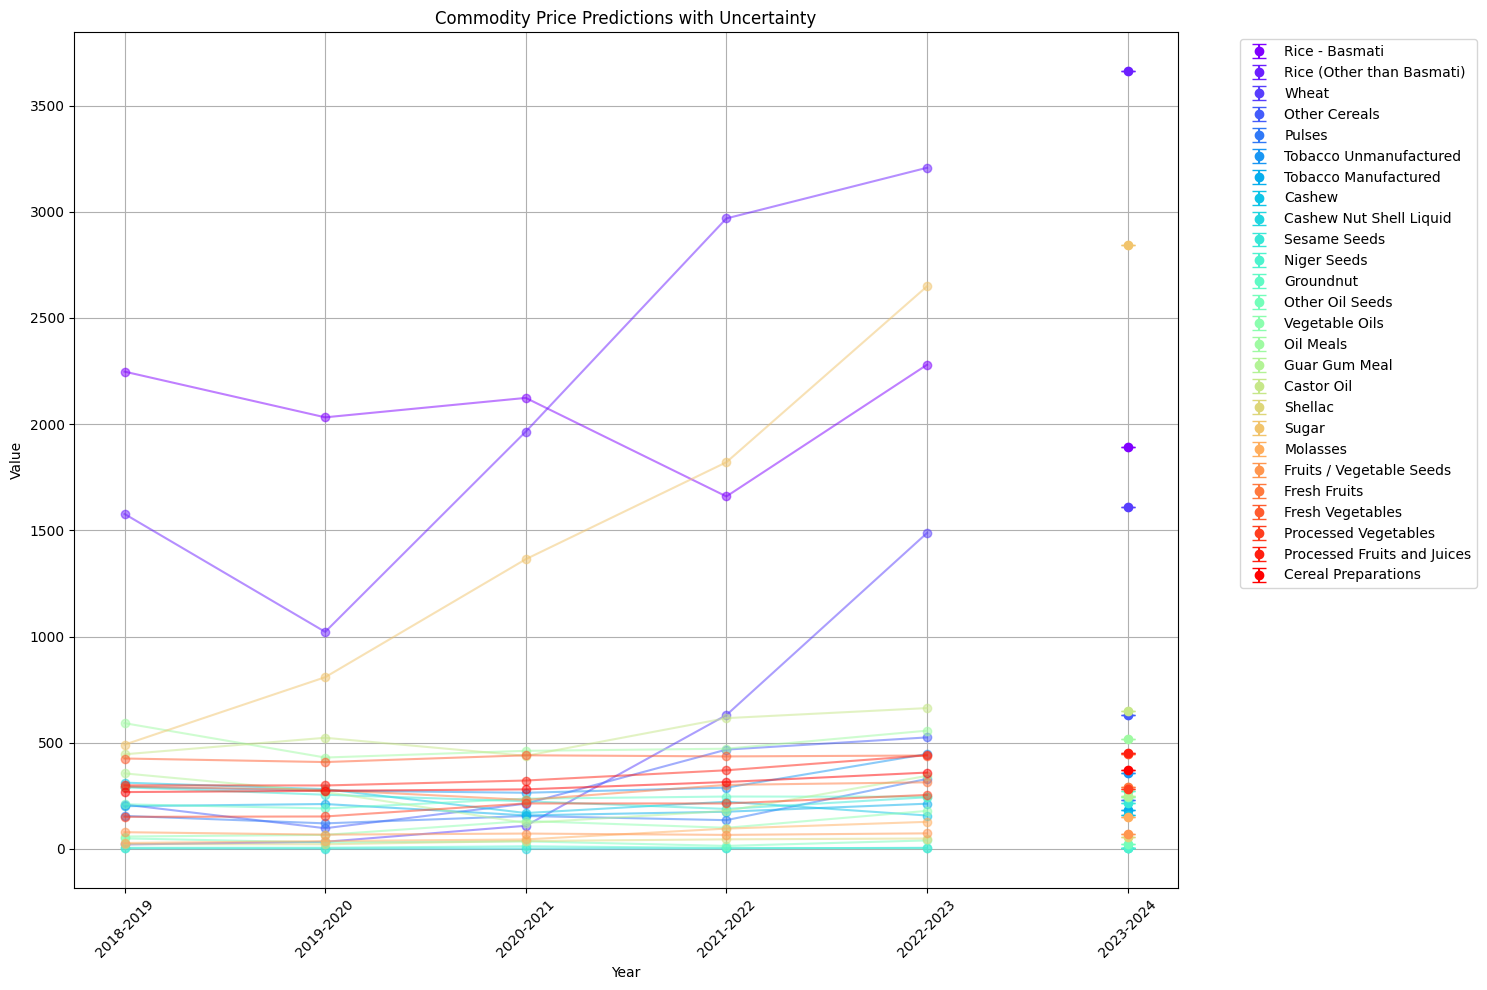

In [3]:
# ... (Previous imports remain the same)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# ... (Previous functions remain the same until predict_commodities)

def evaluate_predictions(df, predictions):
    """
    Calculate evaluation metrics for the predictions
    """
    metrics = {}
    actual_values = []
    predicted_values = []
    
    # Get the last year's actual values for comparison
    last_year = df.columns[-1]
    for commodity in df['Commodity']:
        actual = df[df['Commodity'] == commodity][last_year].values[0]
        predicted = predictions[commodity]
        actual_values.append(actual)
        predicted_values.append(predicted)
        
        # Calculate individual commodity metrics
        metrics[commodity] = {
            'RMSE': math.sqrt(mean_squared_error([actual], [predicted])),
            'MAE': mean_absolute_error([actual], [predicted]),
            'R2': r2_score([actual], [predicted]) if actual != predicted else 1.0
        }
    
    # Calculate overall metrics
    overall_metrics = {
        'Overall_RMSE': math.sqrt(mean_squared_error(actual_values, predicted_values)),
        'Overall_MAE': mean_absolute_error(actual_values, predicted_values),
        'Overall_R2': r2_score(actual_values, predicted_values)
    }
    
    return metrics, overall_metrics, actual_values, predicted_values

def plot_evaluation_metrics(metrics, overall_metrics):
    """
    Create visualizations for evaluation metrics
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. RMSE by Commodity
    plt.subplot(2, 2, 1)
    commodities = list(metrics.keys())
    rmse_values = [m['RMSE'] for m in metrics.values()]
    
    plt.bar(range(len(commodities)), rmse_values)
    plt.xticks(range(len(commodities)), commodities, rotation=90)
    plt.title('RMSE by Commodity')
    plt.ylabel('RMSE')
    
    # Add overall RMSE as horizontal line
    plt.axhline(y=overall_metrics['Overall_RMSE'], color='r', linestyle='--', 
                label=f'Overall RMSE: {overall_metrics["Overall_RMSE"]:.2f}')
    plt.legend()
    
    # 2. Actual vs Predicted Scatter Plot
    plt.subplot(2, 2, 2)
    actual_values = [df[df['Commodity'] == comm][df.columns[-1]].values[0] 
                    for comm in commodities]
    predicted_values = [predictions[comm] for comm in commodities]
    
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot([min(actual_values), max(actual_values)], 
             [min(actual_values), max(actual_values)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted (R² = {overall_metrics["Overall_R2"]:.3f})')
    
    # Add commodity labels to points
    for i, commodity in enumerate(commodities):
        plt.annotate(commodity, (actual_values[i], predicted_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Prediction Error Distribution
    plt.subplot(2, 2, 3)
    errors = np.array(predicted_values) - np.array(actual_values)
    sns.histplot(errors, kde=True)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    
    # 4. MAE by Commodity
    plt.subplot(2, 2, 4)
    mae_values = [m['MAE'] for m in metrics.values()]
    
    plt.bar(range(len(commodities)), mae_values)
    plt.xticks(range(len(commodities)), commodities, rotation=90)
    plt.title('MAE by Commodity')
    plt.ylabel('MAE')
    
    # Add overall MAE as horizontal line
    plt.axhline(y=overall_metrics['Overall_MAE'], color='r', linestyle='--', 
                label=f'Overall MAE: {overall_metrics["Overall_MAE"]:.2f}')
    plt.legend()
    
    plt.tight_layout()
    return fig

def print_metrics_report(metrics, overall_metrics):
    """
    Print a detailed metrics report
    """
    print("\nModel Evaluation Metrics")
    print("=" * 50)
    print("\nOverall Metrics:")
    print(f"Overall RMSE: {overall_metrics['Overall_RMSE']:.2f}")
    print(f"Overall MAE: {overall_metrics['Overall_MAE']:.2f}")
    print(f"Overall R²: {overall_metrics['Overall_R2']:.3f}")
    
    print("\nMetrics by Commodity:")
    print("-" * 50)
    print(f"{'Commodity':<30} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    print("-" * 50)
    
    for commodity, metric in metrics.items():
        print(f"{commodity:<30} {metric['RMSE']:>10.2f} {metric['MAE']:>10.2f} {metric['R2']:>10.3f}")

def main():
    # Load data
    df = load_data()
    
    # Make predictions
    predictions, uncertainties = predict_commodities(df)
    
    # Calculate evaluation metrics
    metrics, overall_metrics, actual_values, predicted_values = evaluate_predictions(df, predictions)
    
    # Print detailed metrics report
    print_metrics_report(metrics, overall_metrics)
    
    # Create and show predictions visualization
    pred_plt = plot_predictions(df, predictions, uncertainties)
    pred_plt.figure.savefig('predictions.png', bbox_inches='tight')
    pred_plt.close()
    
    # Create and show evaluation metrics visualization
    eval_plt = plot_evaluation_metrics(metrics, overall_metrics)
    plt.savefig('evaluation_metrics.png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

In [4]:
def plot_predictions(df, predictions, uncertainties):
    """
    Create visualization for predictions with uncertainty
    """
    fig = plt.figure(figsize=(15, 10))
    
    # Plot actual values and predictions for each commodity
    years = df.columns[1:].astype(str)
    next_year = '2023-2024'
    
    # Create a color map for different commodities
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df['Commodity'])))
    
    for idx, commodity in enumerate(df['Commodity']):
        values = df[df['Commodity'] == commodity].iloc[:, 1:].values.flatten()
        color = colors[idx]
        
        # Plot historical values
        plt.plot(years, values, marker='o', color=color, alpha=0.5)
        
        # Plot prediction with uncertainty
        plt.errorbar(next_year, predictions[commodity], 
                    yerr=uncertainties[commodity], 
                    fmt='o', capsize=5, color=color,
                    label=commodity)
    
    plt.title('Commodity Price Predictions with Uncertainty')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return fig

def plot_evaluation_metrics(df, metrics, overall_metrics, predictions):
    """
    Create visualizations for evaluation metrics
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. RMSE by Commodity
    plt.subplot(2, 2, 1)
    commodities = list(metrics.keys())
    rmse_values = [m['RMSE'] for m in metrics.values()]
    
    plt.bar(range(len(commodities)), rmse_values)
    plt.xticks(range(len(commodities)), commodities, rotation=90)
    plt.title('RMSE by Commodity')
    plt.ylabel('RMSE')
    
    # Add overall RMSE as horizontal line
    plt.axhline(y=overall_metrics['Overall_RMSE'], color='r', linestyle='--', 
                label=f'Overall RMSE: {overall_metrics["Overall_RMSE"]:.2f}')
    plt.legend()
    
    # 2. Actual vs Predicted Scatter Plot
    plt.subplot(2, 2, 2)
    actual_values = [df[df['Commodity'] == comm][df.columns[-1]].values[0] 
                    for comm in commodities]
    predicted_values = [predictions[comm] for comm in commodities]
    
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot([min(actual_values), max(actual_values)], 
             [min(actual_values), max(actual_values)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted (R² = {overall_metrics["Overall_R2"]:.3f})')
    
    # Add commodity labels to points
    for i, commodity in enumerate(commodities):
        plt.annotate(commodity, (actual_values[i], predicted_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Prediction Error Distribution
    plt.subplot(2, 2, 3)
    errors = np.array(predicted_values) - np.array(actual_values)
    sns.histplot(errors, kde=True)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    
    # 4. MAE by Commodity
    plt.subplot(2, 2, 4)
    mae_values = [m['MAE'] for m in metrics.values()]
    
    plt.bar(range(len(commodities)), mae_values)
    plt.xticks(range(len(commodities)), commodities, rotation=90)
    plt.title('MAE by Commodity')
    plt.ylabel('MAE')
    
    # Add overall MAE as horizontal line
    plt.axhline(y=overall_metrics['Overall_MAE'], color='r', linestyle='--', 
                label=f'Overall MAE: {overall_metrics["Overall_MAE"]:.2f}')
    plt.legend()
    
    plt.tight_layout()
    return fig

def main():
    # Load data
    df = load_data()
    
    # Make predictions
    predictions, uncertainties = predict_commodities(df)
    
    # Calculate evaluation metrics
    metrics, overall_metrics, actual_values, predicted_values = evaluate_predictions(df, predictions)
    
    # Print detailed metrics report
    print_metrics_report(metrics, overall_metrics)
    
    # Create and save predictions visualization
    pred_fig = plot_predictions(df, predictions, uncertainties)
    pred_fig.savefig('predictions.png', bbox_inches='tight', dpi=300)
    plt.close(pred_fig)
    
    # Create and save evaluation metrics visualization
    eval_fig = plot_evaluation_metrics(df, metrics, overall_metrics, predictions)
    eval_fig.savefig('evaluation_metrics.png', bbox_inches='tight', dpi=300)
    plt.close(eval_fig)
    
    print("\nVisualization files have been saved:")
    print("1. predictions.png - Shows predictions with uncertainty bands")
    print("2. evaluation_metrics.png - Shows evaluation metrics and error analysis")

if __name__ == "__main__":
    main()

c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rudra\AppData\Local\Programs\Python\Python311\L


Model Evaluation Metrics

Overall Metrics:
Overall RMSE: 192.24
Overall MAE: 89.11
Overall R²: 0.946

Metrics by Commodity:
--------------------------------------------------
Commodity                            RMSE        MAE         R²
--------------------------------------------------
Rice - Basmati                     374.33     374.33        nan
Rice (Other than Basmati)          756.32     756.32        nan
Wheat                               55.79      55.79        nan
Other Cereals                      103.94     103.94        nan
Pulses                             107.70     107.70        nan
Tobacco Unmanufactured              75.37      75.37        nan
Tobacco Manufactured                30.56      30.56        nan
Cashew                               7.72       7.72        nan
Cashew Nut Shell Liquid              1.84       1.84        nan
Sesame Seeds                        18.38      18.38        nan
Niger Seeds                          0.66       0.66        nan
Groun